<a href="https://colab.research.google.com/github/adityanarayan-rai/flood_detection_ban/blob/main/01_flood_jamalpur_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# -------------------------------
# Install & Import Dependencies
# -------------------------------

!pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00


In [9]:
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, MimeType, DataCollection, bbox_to_dimensions

In [10]:
# Configure Sentinel Hub Access

# Setup config
config = SHConfig()
# Uncomment and set these if not stored in config file
config.sh_client_id = "e3cc4ef5-1042-430a-9fbd-1ca499134e54"
config.sh_client_secret = "IHkGxCm3EZwVaeUiOrVzJOKTggL04Yp6"

In [11]:
# Define Area of Interest (Jamalpur)

jamalpur_bbox_coords = [89.85, 25.00, 89.98, 25.12]
resolution = 20

bbox = BBox(bbox=jamalpur_bbox_coords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

In [12]:
# Download Sentinel-1 SAR Imagery (VV band)
# Used to detect flooding based on backscatter change

sar_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["VV"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  return [sample.VV];
}
"""

# Pre-flood
sar_pre_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-06-15', '2020-06-25'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_pre_image = sar_pre_request.get_data()[0]

# Post-flood
sar_post_request = SentinelHubRequest(
    evalscript=sar_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL1,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='mostRecent'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
sar_post_image = sar_post_request.get_data()[0]

In [13]:
# Download Sentinel-2 NDVI
# Used to estimate vegetation loss (crop damage)
# NDVI = (NIR - Red) / (NIR + Red)

ndvi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B08", "B04"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  return [ndvi];
}
"""

ndvi_request = SentinelHubRequest(
    evalscript=ndvi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndvi_image = ndvi_request.get_data()[0]


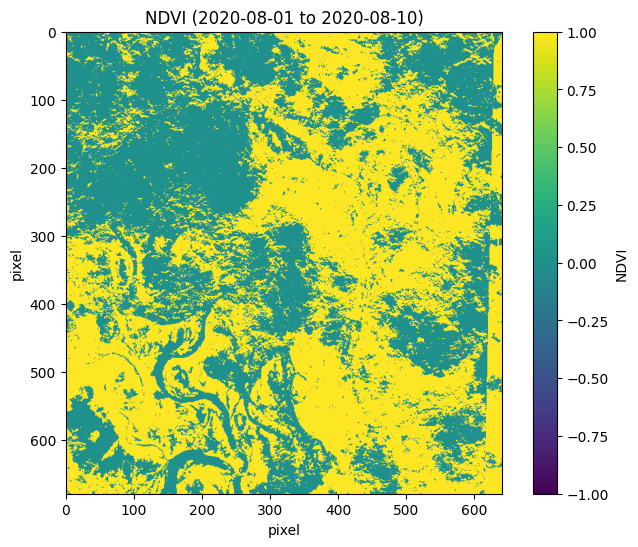

In [14]:
import matplotlib.pyplot as plt

# ndvi_image comes back as a 2D or 3D array: squeeze out any singleton dim
ndvi = ndvi_image.squeeze()

plt.figure(figsize=(8, 6))
# NDVI typically runs from –1 to +1
plt.imshow(ndvi, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

In [16]:
# Compute NDWI from Sentinel-2
# Used to detect surface water (floods)
# NDWI = (Green - NIR) / (Green + NIR)

ndwi_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B03", "B08"],
    output: { bands: 1 }
  };
}
function evaluatePixel(sample) {
  var ndwi = (sample.B03 - sample.B08) / (sample.B03 + sample.B08);
  return [ndwi];
}
"""

ndwi_request = SentinelHubRequest(
    evalscript=ndwi_evalscript,
    input_data=[SentinelHubRequest.input_data(
        data_collection=DataCollection.SENTINEL2_L2A,
        time_interval=('2020-08-01', '2020-08-10'),
        mosaicking_order='leastCC'
    )],
    responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config
)
ndwi_image = ndwi_request.get_data()[0]


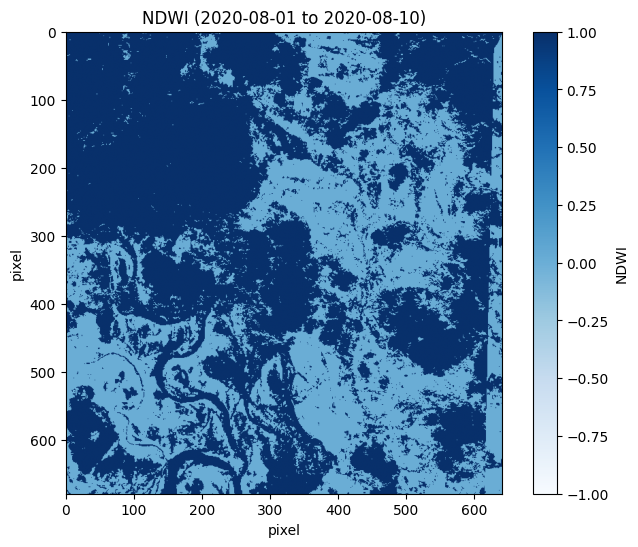

In [17]:
# Visualize NDWI Map

ndwi = ndwi_image.squeeze()

plt.figure(figsize=(8, 6))
plt.imshow(ndwi, vmin=-1, vmax=1, cmap='Blues')
plt.colorbar(label='NDWI')
plt.title('NDWI (2020-08-01 to 2020-08-10)')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.show()

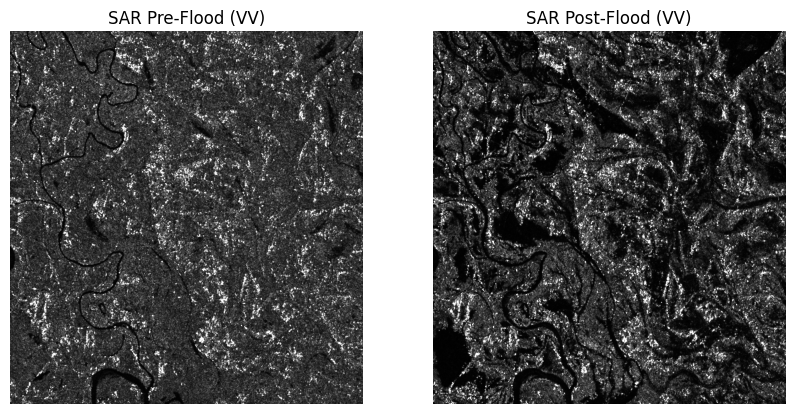

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('SAR Pre-Flood (VV)')
plt.imshow(sar_pre_image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('SAR Post-Flood (VV)')
plt.imshow(sar_post_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()


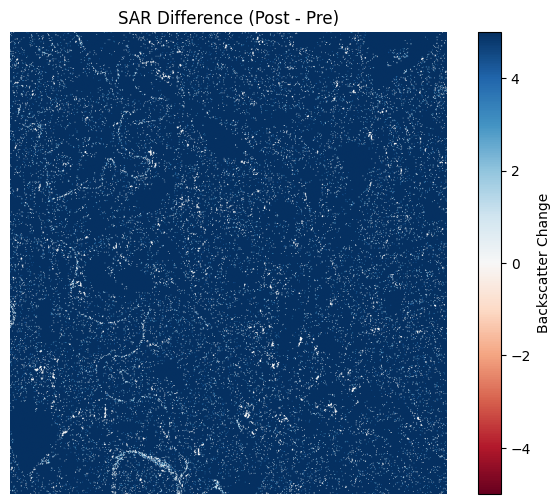

In [19]:
import numpy as np

# Compute SAR difference
sar_diff = sar_post_image.squeeze() - sar_pre_image.squeeze()

plt.figure(figsize=(8, 6))
plt.imshow(sar_diff, cmap='RdBu', vmin=-5, vmax=5)
plt.title('SAR Difference (Post - Pre)')
plt.colorbar(label='Backscatter Change')
plt.axis('off')
plt.show()

Generate Binary Flood Mask from NDWI
This mask will serve as pseudo-ground-truth for classification.

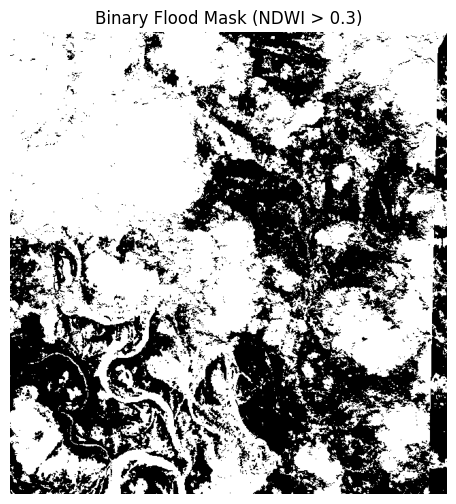

In [20]:
# Threshold NDWI to detect water (e.g., NDWI > 0.3)
flood_mask = (ndwi > 0.3).astype(int)

plt.figure(figsize=(6, 6))
plt.imshow(flood_mask, cmap='gray')
plt.title('Binary Flood Mask (NDWI > 0.3)')
plt.axis('off')
plt.show()


Create Feature Matrix for Classification
Stack SAR diff, NDWI, and NDVI as input features.

In [21]:
# Flatten arrays and stack features
# Use only SAR difference to predict damage classes (avoids leakage from NDVI/NDWI)
X = sar_diff.ravel().reshape(-1, 1)

y = flood_mask.ravel()

# Remove invalid pixels (NaNs)
valid_mask = ~np.isnan(X).any(axis=1)
X_clean = X[valid_mask]
y_clean = y[valid_mask]

Train a Random Forest Classifier
This classifies pixels as flooded or not based on input features.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Train RF model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.48      0.01      0.03     52133
           1       0.60      0.99      0.75     78643

    accuracy                           0.60    130776
   macro avg       0.54      0.50      0.39    130776
weighted avg       0.55      0.60      0.46    130776



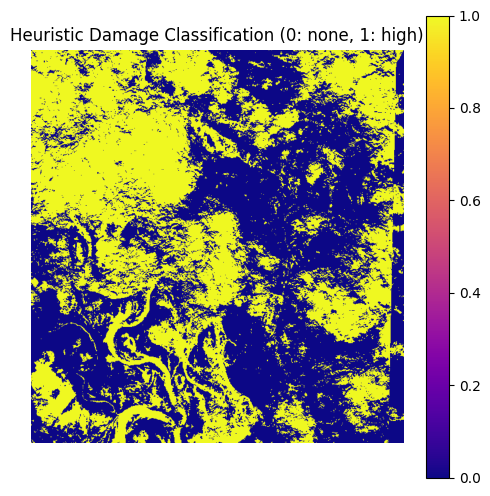

In [41]:
# NDWI (water) + NDVI (vegetation health) → damage class
# 0 = no damage, 1 = flooded but green (low), 2 = flooded + vegetation loss (high)

damage_mask = np.zeros_like(ndvi, dtype=np.uint8)
damage_mask[(ndwi > 0.3) & (ndvi < 0.3)] = 1  # flooded and NDVI loss = high damage
# everything else is 0

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(damage_mask, cmap='plasma')
plt.title('Heuristic Damage Classification (0: none, 1: high)')
plt.colorbar()
plt.axis('off')
plt.show()


array([[  4,  36,  24, ..., 172, 249,  20],
       [ 17,  30,   0, ...,  45,  12,  37],
       [  5,  23,  44, ..., 221, 253,  69],
       ...,
       [216, 233, 249, ..., 229, 210, 247],
       [243, 224, 241, ..., 245, 226, 214],
       [246, 232, 242, ..., 251, 224, 228]], dtype=uint8)
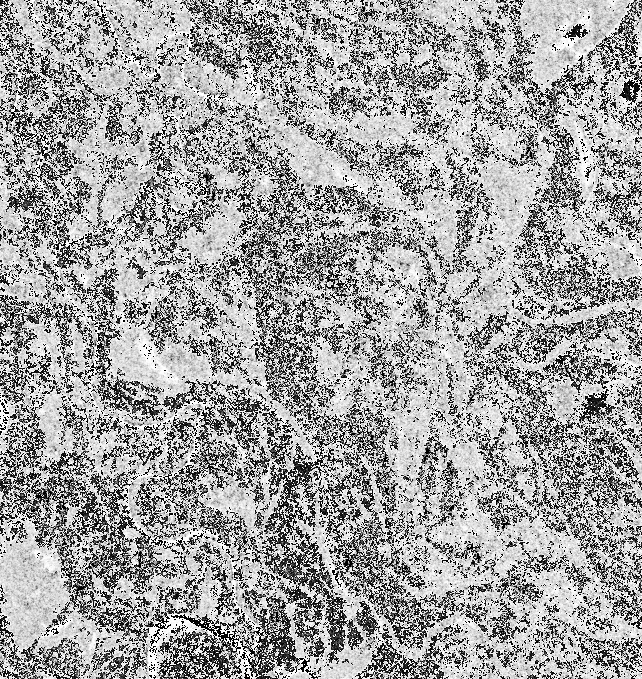

In [34]:
sar_diff

In [39]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print("Training label distribution:", dict(zip(unique, counts)))

Training label distribution: {np.uint8(0): np.int64(163199), np.uint8(1): np.int64(141943)}


Predict Flood Map
Apply model to full image and reshape to original size.

In [37]:
# Stack features: SAR difference, NDVI, NDWI
X = sar_diff.ravel().reshape(-1, 1)

y = damage_mask.ravel()

# Filter out invalid pixels (NaNs or Infs)
mask = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1)
X_clean = X[mask]
y_clean = y[mask]


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.54      0.79      0.64     69884
           1       0.50      0.24      0.33     60892

    accuracy                           0.53    130776
   macro avg       0.52      0.52      0.49    130776
weighted avg       0.52      0.53      0.50    130776



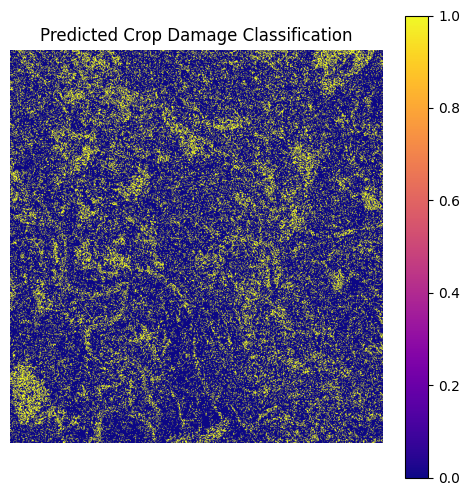

In [40]:
# Predict for all valid pixels
y_pred_full = clf.predict(X_clean)

# Rebuild full-size image
damage_prediction = np.zeros_like(y, dtype=np.uint8)
damage_prediction[mask] = y_pred_full
damage_prediction = damage_prediction.reshape(damage_mask.shape)

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(damage_prediction, cmap='plasma')
plt.title('Predicted Crop Damage Classification')
plt.colorbar()
plt.axis('off')
plt.show()


In [42]:
import numpy as np

# Parameters for grid
tile_size = 10  # each "parcel" is 10x10 pixels
n_rows, n_cols = damage_prediction.shape

# Compute number of tiles
n_tiles_y = n_rows // tile_size
n_tiles_x = n_cols // tile_size

parcel_scores = []

for i in range(n_tiles_y):
    for j in range(n_tiles_x):
        y0, y1 = i * tile_size, (i + 1) * tile_size
        x0, x1 = j * tile_size, (j + 1) * tile_size
        tile = damage_prediction[y0:y1, x0:x1]

        # Calculate stats
        total_pixels = tile.size
        high_damage = np.sum(tile == 2)
        mean_ndvi = np.mean(ndvi[y0:y1, x0:x1])

        # % of high damage pixels
        pct_high = high_damage / total_pixels

        # Assign risk level
        if pct_high > 0.6:
            risk = "High"
        elif pct_high > 0.3:
            risk = "Medium"
        else:
            risk = "Low"

        parcel_scores.append({
            "parcel_id": f"P_{i}_{j}",
            "row": i,
            "col": j,
            "pct_high_damage": round(pct_high * 100, 1),
            "mean_ndvi": round(mean_ndvi, 3),
            "risk_level": risk
        })


In [44]:
import pandas as pd

df_parcels = pd.DataFrame(parcel_scores)
df_parcels.head()


parcel_id  row  col  pct_high_damage  mean_ndvi risk_level
0     P_0_0    0    0              0.0       0.67        Low
1     P_0_1    0    1              0.0       0.04        Low
2     P_0_2    0    2              0.0       0.00        Low
3     P_0_3    0    3              0.0       0.00        Low
4     P_0_4    0    4              0.0       1.43        Low

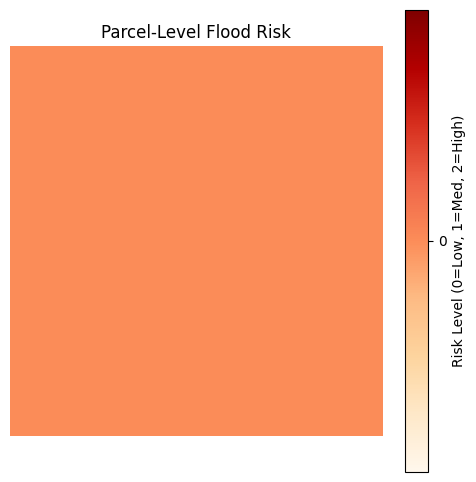

In [45]:
# Create a matrix of risk levels to visualize
risk_map = np.zeros((n_tiles_y, n_tiles_x), dtype=np.uint8)
for p in parcel_scores:
    r, c = p["row"], p["col"]
    if p["risk_level"] == "High":
        risk_map[r, c] = 2
    elif p["risk_level"] == "Medium":
        risk_map[r, c] = 1
    else:
        risk_map[r, c] = 0

plt.figure(figsize=(6, 6))
plt.imshow(risk_map, cmap='OrRd')
plt.title('Parcel-Level Flood Risk')
plt.colorbar(ticks=[0,1,2], label='Risk Level (0=Low, 1=Med, 2=High)')
plt.axis('off')
plt.show()


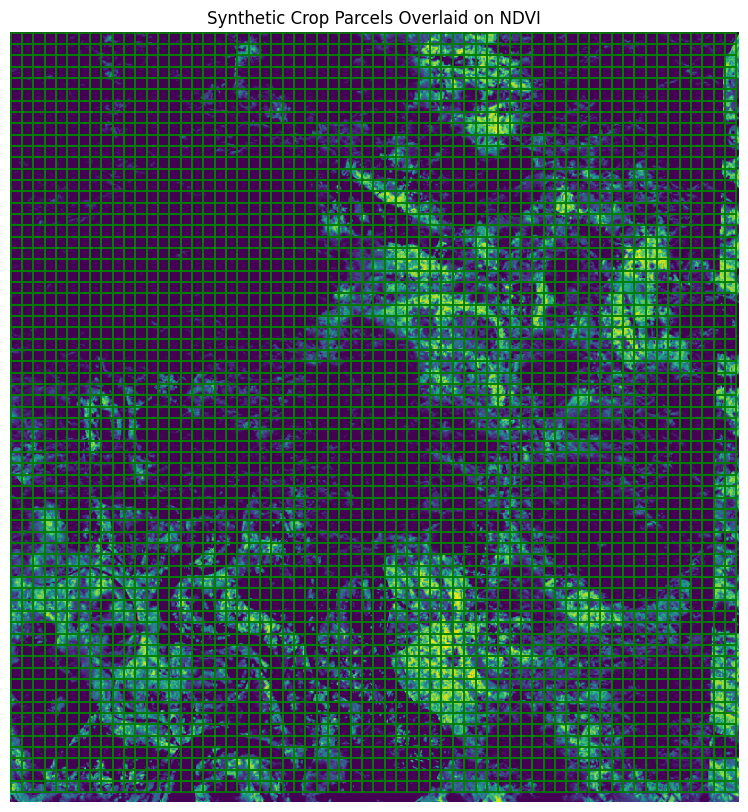

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose the base image to show under the grid
base_image = ndvi  # or sar_diff, or damage_prediction

# Setup plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(base_image, cmap='gray' if base_image is sar_diff else 'viridis')
ax.set_title('Synthetic Crop Parcels Overlaid on NDVI')
ax.axis('off')

# Draw rectangles (parcels)
for parcel in parcel_scores:
    r = parcel["row"]
    c = parcel["col"]
    risk = parcel["risk_level"]

    # Define rectangle coordinates
    rect = patches.Rectangle(
        (c * tile_size, r * tile_size),
        tile_size,
        tile_size,
        linewidth=1.2,
        edgecolor='red' if risk == "High" else 'orange' if risk == "Medium" else 'green',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()


In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy = accuracy_score(damage_mask.ravel(), damage_prediction.ravel())
print(f"Pixel-wise accuracy (vs pseudo-label): {accuracy:.2f}")


Pixel-wise accuracy (vs pseudo-label): 0.54


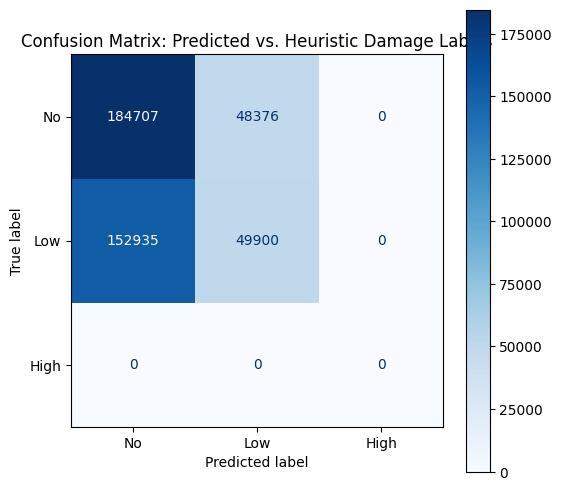

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten predictions and labels
y_true = damage_mask.ravel()
y_pred = damage_prediction.ravel()

# Filter out invalid pixels (if you have a valid mask already, use it)
mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Low", "High"])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format='d')
plt.title("Confusion Matrix: Predicted vs. Heuristic Damage Labels")
plt.show()
